 0 processing
 1 processing
 2 processing
 3 processing
 4 processing
 5 processing
 6 processing
 7 processing
 8 processing
 9 processing
 10 processing
 11 processing
 12 processing
 13 processing
 14 processing
 15 processing
 16 processing
 17 processing
 18 processing
 19 processing
 20 processing
 21 processing
 22 processing
 23 processing
 24 processing
 25 processing
 26 processing
 27 processing
 28 processing
 29 processing
Average output of the teacher network: -0.2930804173935054
Teacher overlaps matrix:
 [[ 0.94361571 -0.07749477 -0.00954377]
 [-0.07749477  0.95099121 -0.08531648]
 [-0.00954377 -0.08531648  1.02561419]]


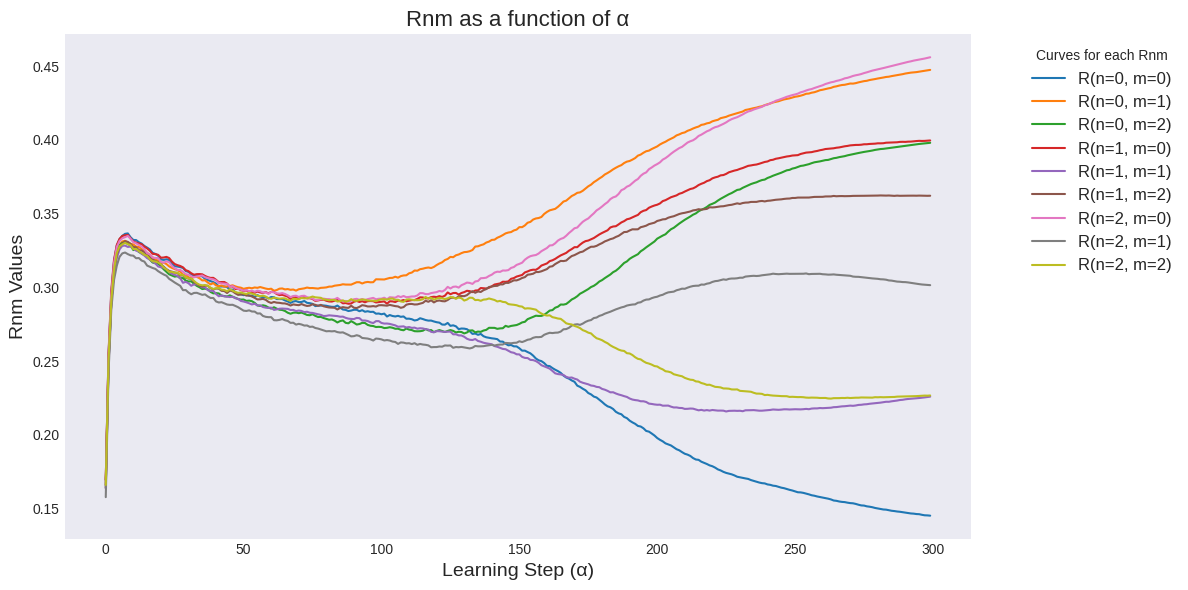

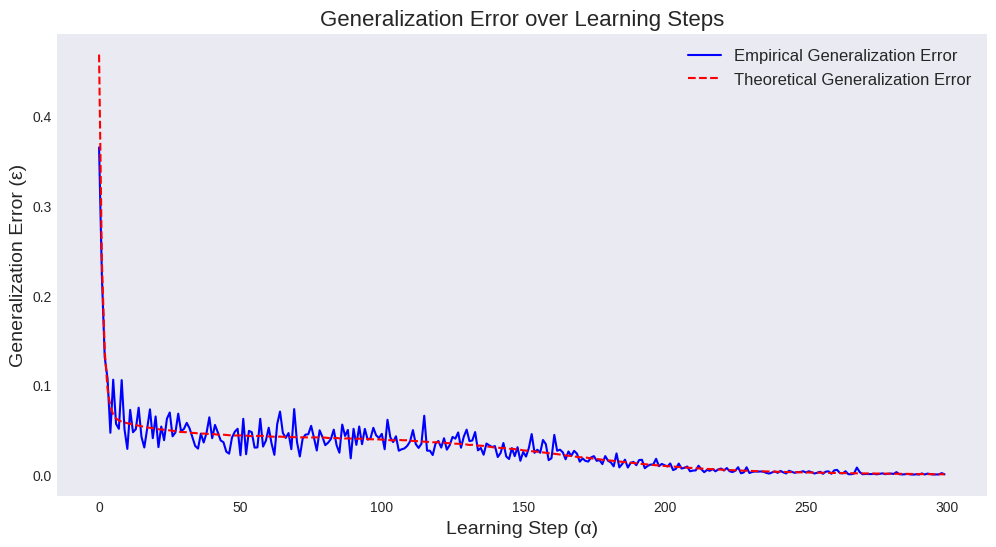

In [4]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['grid.linestyle'] = '--'

np.random.seed(338)
N = 1000
hidden_units = 3
samples = 30
learning_rate = 0.7
alpha_steps = 300

teacher_outputs = []
inputs = []
R_samples = np.zeros((50, alpha_steps, hidden_units, hidden_units))
generalization_errors_samples = np.zeros((50, alpha_steps))
theoretical_errors_samples = np.zeros((50, alpha_steps))

for sample in range(50):
    print(f' {sample} processing')

    teacher_weights = np.random.normal(0, np.sqrt(1 / N), (hidden_units, N))
    input_vector = np.random.normal(0, 1, N)
    inputs.append(input_vector)

    fields = np.dot(teacher_weights, input_vector)
    activations = erf(fields / np.sqrt(2))
    teacher_output = np.sum(activations)
    teacher_outputs.append(teacher_output)

    student_weights = np.random.normal(0, np.sqrt(1 / N), (hidden_units, N))
    R_values = np.zeros((alpha_steps, hidden_units, hidden_units))
    generalization_errors = np.zeros(alpha_steps)
    theoretical_errors = np.zeros(alpha_steps)

    for alpha in range(alpha_steps):
        for _ in range(1000):
            input_vector = np.random.normal(0, 1, N)

            teacher_output = np.sum(erf(np.dot(teacher_weights, input_vector) / np.sqrt(2)))
            fields_student = np.dot(student_weights, input_vector)
            student_activations = erf(fields_student / np.sqrt(2))
            student_output = np.sum(student_activations)
            loss = teacher_output - student_output

            for n in range(hidden_units):
                student_weights[n] += learning_rate / N * (np.sqrt(2) / np.sqrt(np.pi)) * np.exp(-fields_student[n] ** 2 / 2) * loss * input_vector

        R = np.dot(student_weights, teacher_weights.T)
        Q = np.dot(student_weights, student_weights.T)
        T = np.dot(teacher_weights, teacher_weights.T)
        R_values[alpha] = R

        examples = np.random.normal(0, 1, (1000, N))
        teacher_outputs_example = np.array([np.sum(erf(np.dot(teacher_weights, example) / np.sqrt(2))) for example in examples])
        student_outputs_example = np.array([np.sum(erf(np.dot(student_weights, example) / np.sqrt(2))) for example in examples])
        average_error = 0.5 * (np.sum(teacher_outputs_example) - np.sum(student_outputs_example)) ** 2 / 1000
        generalization_errors[alpha] = average_error

        sum_Q = np.sum(np.arcsin(Q / (np.sqrt(1 + np.diag(Q)[:, None]) * np.sqrt(1 + np.diag(Q)[None, :]))))
        sum_T = np.sum(np.arcsin(T / (np.sqrt(1 + np.diag(T)[:, None]) * np.sqrt(1 + np.diag(T)[None, :]))))
        sum_R = np.sum(np.arcsin(R / (np.sqrt(1 + np.diag(Q)[:, None]) * np.sqrt(1 + np.diag(T)[None, :]))))
        theor_error = (1 / np.pi) * (sum_Q + sum_T - 2 * sum_R)
        theoretical_errors[alpha] = theor_error

    R_samples[sample] = R_values
    generalization_errors_samples[sample] = generalization_errors
    theoretical_errors_samples[sample] = theoretical_errors

average_teacher_output = np.mean(teacher_outputs)
print(f"Average output of the teacher network: {average_teacher_output}")
teacher_overlaps = np.dot(teacher_weights, teacher_weights.T)
print("Teacher overlaps matrix:\n", teacher_overlaps)

student_outputs = []
for input_vector in inputs:
    student_fields = np.dot(student_weights, input_vector)
    student_activations = erf(student_fields / np.sqrt(2))
    student_output = np.sum(student_activations)
    student_outputs.append(student_output)

average_R_nm = np.mean(R_samples, axis=0)
plt.figure(figsize=(12, 6))
for n in range(hidden_units):
    for m in range(hidden_units):
        plt.plot(average_R_nm[:, n, m], label=f'R(n={n}, m={m})', linestyle='-')
plt.title('Rnm as a function of α')
plt.xlabel('Learning Step (α)')
plt.ylabel('Rnm Values')
plt.legend(title='Curves for each Rnm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

generalization_errors = np.mean(generalization_errors_samples, axis=0)
theoretical_errors = np.mean(theoretical_errors_samples, axis=0)
plt.plot(range(alpha_steps), generalization_errors, label='Empirical Generalization Error', color='blue')
plt.plot(range(alpha_steps), theoretical_errors, label='Theoretical Generalization Error', color='red', linestyle='dashed')
plt.title('Generalization Error over Learning Steps')
plt.xlabel('Learning Step (α)')
plt.ylabel('Generalization Error (ε)')
plt.legend()
plt.grid()
plt.show()